<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/QW1D_evolutionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.8 MB/s eta 0:00:00


Starting Evolutionary Algorithm ... Pop: 20, Gens: 10, Sim Depth: 100

Gen 1: Avg Fitness: 123.33, Gen Best: 215.41 (Overall Best: 215.41)
Gen 2: Avg Fitness: 140.67, Gen Best: 215.41 (Overall Best: 215.41)
Gen 3: Avg Fitness: 162.55, Gen Best: 215.41 (Overall Best: 215.41)
Gen 4: Avg Fitness: 188.38, Gen Best: 215.41 (Overall Best: 215.41)
Gen 5: Avg Fitness: 195.47, Gen Best: 215.41 (Overall Best: 215.41)
Gen 6: Avg Fitness: 179.76, Gen Best: 215.41 (Overall Best: 215.41)
Gen 7: Avg Fitness: 181.26, Gen Best: 215.41 (Overall Best: 215.41)
Gen 8: Avg Fitness: 178.04, Gen Best: 215.41 (Overall Best: 215.41)
Gen 9: Avg Fitness: 163.67, Gen Best: 215.41 (Overall Best: 215.41)
Gen 10: Avg Fitness: 198.16, Gen Best: 215.41 (Overall Best: 215.41)

--- Evolutionary Algorithm Finished (or stopped for debug) ---
Best Genome Found Overall (Fitness: 215.4050):
{'ca_rule': np.int64(90), 'c0_name': np.str_('Rz4'), 'c1_name': np.str_('X'), 'p_thresh': 0.027694610802879993, 'feedback': np.str_('set_

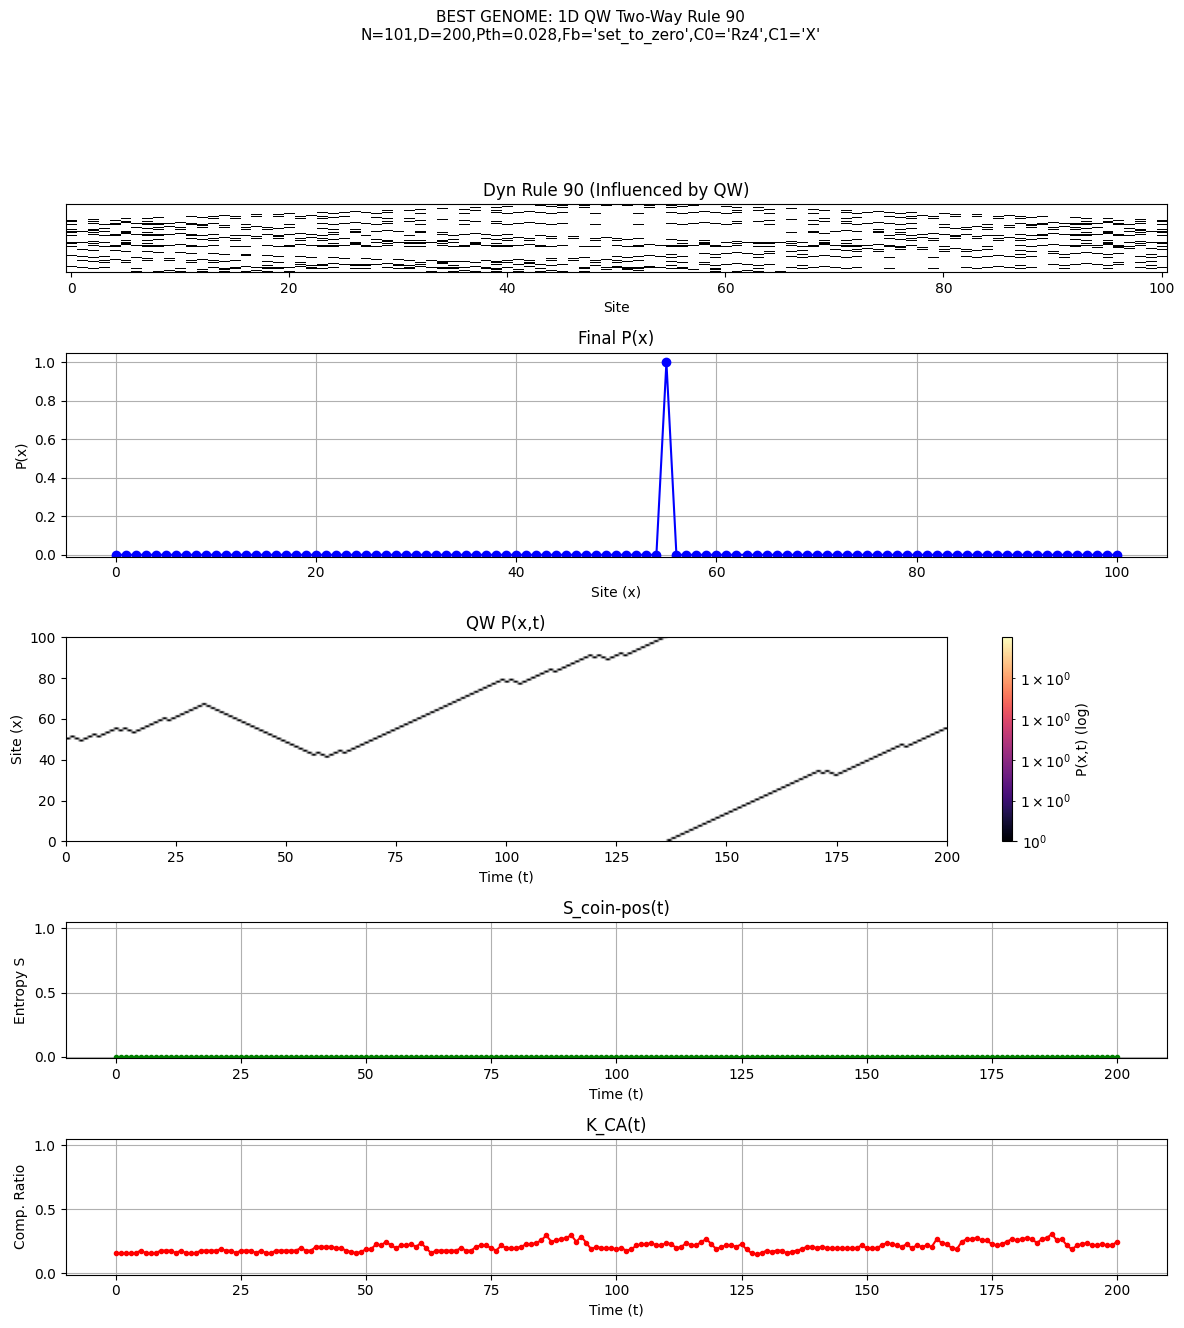


<<<<< END OF EVOLUTIONARY ALGORITHM SIMULATION >>>>>


In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
import zlib
from scipy.signal import find_peaks # For peak detection in fitness

# --- Parameters (Defaults for individual runs, EA will use its own) ---
N_SITES_1D_DEFAULT = 101
DEPTH_DEFAULT = 200    # Default depth for a single run
INITIAL_POS_1D_DEFAULT = N_SITES_1D_DEFAULT // 2
INITIAL_COIN_1D_DEFAULT = 0
INITIAL_CA_CENTER_ONE_DEFAULT = True

# --- CA Rule Update Function ---
def update_ca_line(current_line, rule_number):
    width = len(current_line); new_line = np.zeros(width, dtype=int)
    for i in range(width):
        pattern_val = (current_line[(i-1+width)%width]<<2)|(current_line[i]<<1)|current_line[(i+1)%width]
        if rule_number==30: new_line[i]=1 if pattern_val in [1,2,3,4] else 0
        elif rule_number==90: new_line[i]=1 if current_line[(i-1+width)%width]!=current_line[(i+1)%width] else 0
        elif rule_number==110: new_line[i]=1 if pattern_val in [1,2,3,5,6] else 0
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices & Rz Gate ---
H_1Q = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]],dtype=np.complex128)
I_1Q = np.eye(2,dtype=np.complex128)
def Rz_1Q(angle_rad): return np.array([[np.exp(-1j*angle_rad/2),0],[0,np.exp(1j*angle_rad/2)]],dtype=np.complex128)

# --- Helper Functions (1D QW) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d; initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try: initial_state_vector[get_1d_index(initial_coin_val, initial_pos, n_sites_1d)] = 1.0
    except IndexError as e: print(f"Error during 1D initial state prep: {e}")
    return initial_state_vector

# --- Build QW Step Operator ---
def build_1d_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    state_dim_1d = 2*n_sites_1d
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if current_ca_pattern[site_idx]==0 else coin1_op
        idx_s_c0=get_1d_index(0,site_idx,n_sites_1d); idx_s_c1=get_1d_index(1,site_idx,n_sites_1d)
        C_full[idx_s_c0,idx_s_c0]=chosen_coin_op[0,0]; C_full[idx_s_c1,idx_s_c0]=chosen_coin_op[1,0]
        C_full[idx_s_c0,idx_s_c1]=chosen_coin_op[0,1]; C_full[idx_s_c1,idx_s_c1]=chosen_coin_op[1,1]
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val,site_pos=get_1d_coin_pos_from_index(k_in,n_sites_1d)
        new_pos=(site_pos-1+n_sites_1d)%n_sites_1d if coin_val==0 else (site_pos+1)%n_sites_1d
        S_full[get_1d_index(coin_val,new_pos,n_sites_1d), k_in] = 1.0
    return S_full @ C_full

# --- Observables (1D QW) ---
def calculate_p1_position_1d(sv,n):
    p_dist=np.zeros(n);
    for i in range(n): p_dist[i]=np.abs(sv[get_1d_index(0,i,n)])**2+np.abs(sv[get_1d_index(1,i,n)])**2
    return p_dist

def calculate_coin_position_entanglement_1d(sv,n):
    if np.allclose(sv, 0): return 0.0
    if len(sv)!=2*n:return np.nan
    norm=np.linalg.norm(sv);
    if norm < 1e-9 : return 0.0
    if np.abs(norm-1)>1e-6:sv=sv/norm
    rho=np.outer(sv,np.conj(sv));rho_c=np.zeros((2,2),dtype=np.complex128)
    for i in range(n):
        for r,c in [(x,y) for x in range(2) for y in range(2)]:rho_c[r,c]+=rho[get_1d_index(r,i,n),get_1d_index(c,i,n)]
    tr=np.trace(rho_c)
    if abs(tr) < 1e-9 : return 0.0
    if np.abs(tr-1.0) > 1e-6 : rho_c/=tr
    eigs=np.linalg.eigvalsh(rho_c);ent=0.0
    for e in eigs: ent-=(e*np.log2(e) if e>1e-12 else 0.0)
    return max(0.0,np.real(ent))

def calculate_ca_compressibility(ca_l): return len(zlib.compress("".join(map(str,ca_l)).encode('utf-8')))/len(ca_l) if len(ca_l)>0 else 1.0

# --- Simulation Loop (1D QW with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_two_way_coupling(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    initial_ca_center_one, ca_rule_number, coin0_op, coin1_op,
    p_threshold, feedback_type,
    collect_full_history=False, # This flag mainly controls non-prob_history collection
    verbose_debug_run=False,
    debug_genome_desc=""
):
    if verbose_debug_run:
        print(f"\n--- VERBOSE DEBUG RUN for {debug_genome_desc} ---")
        print(f"  Params: CA_Rule={ca_rule_number}, C0={coin0_op}, C1={coin1_op}, P_Thresh={p_threshold:.3f}, Feedback={feedback_type}")

    current_qw_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0:
        center_idx = n_sites_1d // 2
        if n_sites_1d % 2 == 1: current_ca_line[center_idx] = 1
        else: current_ca_line[center_idx - 1] = 1

    # prob_history is ALWAYS collected fully (depth+1 entries)
    prob_history = np.full((depth + 1, n_sites_1d), np.nan)
    prob_history[0, :] = calculate_p1_position_1d(current_qw_state, n_sites_1d)

    ent_history = [] if collect_full_history else None
    ca_history = [] if collect_full_history else None
    compressibility_history = [] if collect_full_history else None

    if collect_full_history:
        if ent_history is not None: ent_history.append(calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d))
        if ca_history is not None: ca_history.append(current_ca_line.copy())
        if compressibility_history is not None: compressibility_history.append(calculate_ca_compressibility(current_ca_line))

    simulation_status = "completed" # Assume success initially

    for step in range(depth):
        if verbose_debug_run:
            print(f"\nDEBUG_EA_STEP {step+1}/{depth}")
            print(f"  CA Line (first 30): {current_ca_line[:30]}")
            print(f"  QW Norm before U: {np.linalg.norm(current_qw_state):.4e}")

        U_step = build_1d_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)

        if verbose_debug_run and step == 0:
            U_dagger_U = U_step.conj().T @ U_step
            identity_check = np.eye(U_step.shape[0], dtype=np.complex128)
            if not np.allclose(U_dagger_U, identity_check):
                diff_norm = np.linalg.norm(U_dagger_U - identity_check)
                print(f"  WARNING: U_step for step {step+1} may NOT BE UNITARY! Norm of (U_dagger_U - I): {diff_norm:.2e}")
            else:
                print(f"  U_step for step {step+1} appears unitary.")

        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)

        if verbose_debug_run: print(f"  QW Norm after U:  {norm_qw:.4e}")

        if abs(norm_qw) > 1e-9 :
            current_qw_state /= norm_qw
        else:
            if verbose_debug_run:
                print(f"FAILURE: QW Norm zero/too small ({norm_qw:.2e}) at step {step+1}.")
                print(f"  CA Pattern at failure (first 30): {current_ca_line[:30]}")
            simulation_status = "failed_zero_norm"
            # prob_history from this point on will remain NaN (already initialized)
            break # Exit evolution loop

        prob_history[step + 1, :] = calculate_p1_position_1d(current_qw_state, n_sites_1d)

        ca_line_for_next_update = current_ca_line.copy()
        for i in range(n_sites_1d):
            if prob_history[step + 1, i] > p_threshold: # Use current step's probability
                if feedback_type=="flip": ca_line_for_next_update[i]=1-ca_line_for_next_update[i]
                elif feedback_type=="set_to_one": ca_line_for_next_update[i]=1
                elif feedback_type=="set_to_zero": ca_line_for_next_update[i]=0
        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)

        if collect_full_history:
            if ent_history is not None: ent_history.append(calculate_coin_position_entanglement_1d(current_qw_state,n_sites_1d))
            if ca_history is not None: ca_history.append(current_ca_line.copy())
            if compressibility_history is not None: compressibility_history.append(calculate_ca_compressibility(current_ca_line))

    results_dict = {
        "prob_history":np.array(prob_history), # Already an array
        "params": {
            "n_sites":n_sites_1d,"depth":depth,"initial_pos":initial_pos,"initial_coin":initial_coin_val,
            "initial_ca_center_one":initial_ca_center_one,"ca_rule_number":ca_rule_number,
            "p_threshold":p_threshold,"feedback_type":feedback_type, "status": simulation_status
        }
    }
    if ent_history is not None: results_dict["ent_history"] = np.array(ent_history)
    if ca_history is not None: results_dict["ca_history"] = np.array(ca_history)
    if compressibility_history is not None: results_dict["compressibility_history"] = np.array(compressibility_history)
    return results_dict

# --- Fitness Function (Corrected) ---
def calculate_particle_fitness(prob_history, n_sites, depth, target_velocity_range=(0.1, 0.5), target_width=5):
    # This function should now receive a fully populated prob_history (depth+1, n_sites)
    # It will return -2000.0 if any NaNs are present due to early failure.
    if prob_history is None or np.isnan(prob_history).any():
        return -2000.0
    if prob_history.shape[0] != (depth + 1) or prob_history.shape[1] != n_sites : # Check both dimensions
        # print(f"Fitness: prob_history shape mismatch. Expected ({depth+1},{n_sites}), Got {prob_history.shape}")
        return -2100.0 # Different error code for shape mismatch

    start_track_step = depth // 2
    end_track_step = depth

    final_p = prob_history[-1, :]
    if np.sum(final_p) < 1e-6 :
        return -1000.0

    peaks_final_indices, properties = find_peaks(final_p, height=0.01, distance=max(1, target_width // 2))

    if not peaks_final_indices.any():
        return -100.0

    num_good_particles = 0; total_particle_score = 0.0
    for peak_idx_final in peaks_final_indices:
        current_pos = peak_idx_final; num_steps_tracked = 0; path_positions = [current_pos]
        for t in range(end_track_step - 1 , start_track_step - 1, -1):
            p_at_t = prob_history[t, :] # This prob_history row might be NaN if sim failed early
            if np.isnan(p_at_t).any(): break # Path broken if intermediate history is NaN
            search_window_min = max(0, current_pos - target_width)
            search_window_max = min(n_sites, current_pos + target_width + 1)
            if search_window_min >= search_window_max: break
            window_probs = p_at_t[search_window_min:search_window_max]
            if not window_probs.any() or np.max(window_probs) < 0.001 : break
            local_max_idx_in_window = np.argmax(window_probs)
            prev_pos_candidate = search_window_min + local_max_idx_in_window
            if np.abs(prev_pos_candidate - current_pos) <= target_width :
                current_pos = prev_pos_candidate; path_positions.append(current_pos); num_steps_tracked +=1
            else: break

        if num_steps_tracked > (depth // 20):
            path_positions = np.array(path_positions[::-1])
            if len(path_positions) > 1: velocities = np.diff(path_positions)
            else: velocities = np.array([])
            avg_velocity = np.mean(velocities) if len(velocities) > 0 else 0.0
            std_velocity = np.std(velocities) if len(velocities) > 1 else (0.0 if len(velocities) == 1 else 10.0)
            vel_consistency_score = 1.0 / (1.0 + std_velocity)
            vel_magnitude_score = 0.0
            abs_avg_velocity = np.abs(avg_velocity)
            if target_velocity_range[0] <= abs_avg_velocity <= target_velocity_range[1]:
                vel_magnitude_score = 1.0
            elif abs_avg_velocity < target_velocity_range[0] and abs_avg_velocity > 1e-3:
                vel_magnitude_score = 0.2 * (abs_avg_velocity / target_velocity_range[0])
            localization_score = final_p[peak_idx_final]
            if len(peaks_final_indices) > 1:
                localization_score /= (1 + 0.5 * (len(peaks_final_indices)-1) )
            current_particle_score = ( (vel_magnitude_score * 50.0) +
                                       (vel_consistency_score * 30.0) +
                                       (localization_score * 100.0) +
                                       (num_steps_tracked * 1.0) )
            total_particle_score += current_particle_score
            num_good_particles += 1

    if num_good_particles > 0:
        fitness = total_particle_score / num_good_particles
    else:
        if len(peaks_final_indices) > 0:
            peak_positions = peaks_final_indices
            mean_peak_pos = np.mean(peak_positions)
            peak_probs_at_final = final_p[peak_positions]
            squared_deviations = (peak_positions - mean_peak_pos)**2
            variance_numerator = np.sum(squared_deviations * peak_probs_at_final)
            variance_denominator = np.sum(peak_probs_at_final)
            if variance_denominator > 1e-9:
                variance_final = variance_numerator / variance_denominator
            else: variance_final = n_sites**2
            fitness = (np.sum(peak_probs_at_final) * 10.0) * (1.0 / (1.0 + np.sqrt(max(0, variance_final)))) - 50.0
        else: fitness = -75.0

    if np.isnan(fitness) or np.isinf(fitness): fitness = -3000.0
    return fitness

# --- EA Helper Functions, Plotting, Summary (largely unchanged, ensure they use results dict correctly) ---
# (Using the versions from the previous full code block for initialize_population,
#  select_parents_tournament, crossover_genome, mutate_genome,
#  plot_1d_qw_results_two_way, generate_1d_qw_text_output_two_way)
def initialize_population(pop_size, param_choices_dict):
    population = []
    for _ in range(pop_size):
        genome = {
            "ca_rule": np.random.choice(param_choices_dict["ca_rules"]),
            "c0_name": np.random.choice(list(param_choices_dict["coin_ops_dict"].keys())),
            "c1_name": np.random.choice(list(param_choices_dict["coin_ops_dict"].keys())),
            "p_thresh": np.random.uniform(param_choices_dict["p_thresh_range"][0], param_choices_dict["p_thresh_range"][1]),
            "feedback": np.random.choice(param_choices_dict["feedbacks"])
        }
        population.append(genome)
    return population

def select_parents_tournament(population, fitnesses, tournament_size=3, num_parents=None):
    if num_parents is None: num_parents = len(population)
    if not population: return []
    selected_parents = [];
    for _ in range(num_parents):
        actual_tournament_size = min(tournament_size, len(population))
        if actual_tournament_size == 0: break
        comp_idx = np.random.choice(len(population), actual_tournament_size, replace=False)
        comp_fitnesses = np.array(fitnesses)[comp_idx] if fitnesses else np.array([-float('inf')] * len(comp_idx))
        win_idx_in_comp = np.argmax(comp_fitnesses)
        win_idx_in_pop = comp_idx[win_idx_in_comp]
        selected_parents.append(population[win_idx_in_pop])
    return selected_parents

def crossover_genome(p1,p2):
    o1,o2=p1.copy(),p2.copy();keys=list(p1.keys())
    if len(keys)>1:pt=np.random.randint(1,len(keys));
    for i in range(pt,len(keys)):k=keys[i];o1[k],o2[k]=o2[k],o1[k]
    return o1,o2

def mutate_genome(g,p_choices,mut_rate):
    mg=g.copy()
    for k in g:
        if np.random.rand()<mut_rate:
            if k=="ca_rule":mg[k]=np.random.choice(p_choices["ca_rules"])
            elif k=="c0_name":mg[k]=np.random.choice(list(p_choices["coin_ops_dict"].keys()))
            elif k=="c1_name":mg[k]=np.random.choice(list(p_choices["coin_ops_dict"].keys()))
            elif k=="p_thresh":mg[k]=np.random.uniform(p_choices["p_thresh_range"][0],p_choices["p_thresh_range"][1])
            elif k=="feedback":mg[k]=np.random.choice(p_choices["feedbacks"])
    return mg

def plot_1d_qw_results_two_way(results, suptitle_prefix=""):
    params = results["params"]; prob_hist = results.get("prob_history", np.array([]))
    ent_hist = results.get("ent_history", [])
    ca_hist = results.get("ca_history", [])
    compress_hist = results.get("compressibility_history", [])

    depth = params['depth']; ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']
    c0_name = params.get("coin0_name", "C0")
    c1_name = params.get("coin1_name", "C1")
    n_sites_val = params['n_sites']

    num_main_plots = 1
    plot_height_ratios = []

    # Adjust logic for when these histories might be None
    if ca_hist is not None and len(ca_hist) > 0: num_main_plots +=1; plot_height_ratios.append(1)
    plot_height_ratios.append(3)
    if prob_hist is not None and prob_hist.shape[0] > 1: num_main_plots +=1; plot_height_ratios.append(3)
    if ent_hist is not None and len(ent_hist) > 0: num_main_plots +=1; plot_height_ratios.append(2)
    if compress_hist is not None and len(compress_hist) > 0: num_main_plots +=1; plot_height_ratios.append(2)

    if not plot_height_ratios : print("No plottable data."); return

    fig, axs = plt.subplots(num_main_plots, 1, figsize=(12, 2.5 * num_main_plots + 1),
                            gridspec_kw={'height_ratios': plot_height_ratios})
    if num_main_plots == 1: axs = [axs] # Make axs iterable

    title_str = (f"{suptitle_prefix}1D QW Two-Way Rule {ca_rule_number}\n"
                 f"N={n_sites_val},D={depth},Pth={p_thresh:.3f},Fb='{feedback}',C0='{c0_name}',C1='{c1_name}'")
    fig.suptitle(title_str, fontsize=11); pidx=0

    if ca_hist is not None and len(ca_hist) > 0:
        axs[pidx].imshow(ca_hist,cmap='binary',aspect='auto',interpolation='nearest');axs[pidx].set_title(f"Dyn Rule {ca_rule_number} (Influenced by QW)");axs[pidx].set_xlabel("Site");axs[pidx].set_yticks([]);pidx+=1
    elif num_main_plots > 1 and plot_height_ratios[pidx] == 1: # If space was allocated for CA but no data
        axs[pidx].text(0.5,0.5,"CA History Unavailable",ha='center',va='center'); pidx+=1


    if prob_hist is not None and prob_hist.size > 0 and prob_hist.ndim == 2:
        axs[pidx].plot(np.arange(n_sites_val),prob_hist[-1,:],marker='o',ls='-',color='b');axs[pidx].set_title("Final P(x)");axs[pidx].set_xlabel("Site (x)");axs[pidx].set_ylabel("P(x)");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01);pidx+=1
    elif prob_hist is not None and prob_hist.size > 0 and prob_hist.ndim == 1:
        axs[pidx].plot(np.arange(n_sites_val),prob_hist,marker='o',ls='-',color='b');axs[pidx].set_title("Final P(x)");axs[pidx].set_xlabel("Site (x)");axs[pidx].set_ylabel("P(x)");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01);pidx+=1
    else: axs[pidx].text(0.5,0.5,"Prob data unavailable",ha='center',va='center'); pidx+=1

    if prob_hist is not None and prob_hist.ndim == 2 and prob_hist.shape[0] > 1:
        prob_st=prob_hist.T;pos_p=prob_st[prob_st>1e-9];min_v=pos_p.min() if len(pos_p)>0 else 1e-9;max_v=prob_st.max()
        norm_v=colors.LogNorm(vmin=min_v,vmax=max(max_v,min_v+1e-6));im=axs[pidx].imshow(prob_st,aspect='auto',origin='lower',cmap='magma',norm=norm_v,extent=[0,depth,0,n_sites_val-1])
        plt.colorbar(im,ax=axs[pidx],label="P(x,t) (log)");axs[pidx].set_title("QW P(x,t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Site (x)");pidx+=1
    elif num_main_plots > pidx and plot_height_ratios[pidx] == 3 : # If space was allocated for P(x,t)
        axs[pidx].text(0.5,0.5,"P(x,t) History Unavailable",ha='center',va='center'); pidx+=1

    if ent_hist is not None and len(ent_hist) > 0:
        ts=np.arange(len(ent_hist));axs[pidx].plot(ts,ent_hist,marker='.',ls='-',color='g');axs[pidx].set_title("S_coin-pos(t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Entropy S");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01,top=1.05);pidx+=1
    elif num_main_plots > pidx and plot_height_ratios[pidx] == 2: # Space for ent
        axs[pidx].text(0.5,0.5,"Entanglement History Unavailable",ha='center',va='center'); pidx+=1

    if compress_hist is not None and len(compress_hist)>0:
        ts_comp=np.arange(len(compress_hist));axs[pidx].plot(ts_comp,compress_hist,marker='.',ls='-',color='r');axs[pidx].set_title("K_CA(t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Comp. Ratio");axs[pidx].grid(True);max_k_val=np.max(compress_hist[np.isfinite(compress_hist)]) if len(compress_hist[np.isfinite(compress_hist)])>0 else 1;axs[pidx].set_ylim(bottom=-0.01,top=max(1.05,max_k_val+0.05));pidx+=1
    elif num_main_plots > pidx and plot_height_ratios[pidx] == 2: # Space for compress
        axs[pidx].text(0.5,0.5,"Compressibility History Unavailable",ha='center',va='center'); pidx+=1

    plt.tight_layout(rect=[0,0,1,0.90 if num_main_plots > 3 else 0.88]);plt.show() # Adjusted rect slightly

def generate_1d_qw_text_output_two_way(results, genome_params_for_ea=None):
    params = results["params"]; prob_hist = results.get("prob_history", np.array([]))
    ent_hist = results.get("ent_history", []) # Default to empty list
    compress_hist = results.get("compressibility_history", []) # Default to empty list

    ca_rule_number = params['ca_rule_number']; p_thresh = params['p_threshold']; feedback = params['feedback_type']
    c0_name = genome_params_for_ea.get("c0_name", "N/A") if genome_params_for_ea else params.get("coin0_name", "C0")
    c1_name = genome_params_for_ea.get("c1_name", "N/A") if genome_params_for_ea else params.get("coin1_name", "C1")
    n_sites_val = params['n_sites']

    output_lines = [f"\n--- 1D QW (Rule {ca_rule_number},Pth={p_thresh:.3f},Fb='{feedback}',C0='{c0_name}',C1='{c1_name}') Summary ---"]
    output_lines.append(f"N_sites={n_sites_val}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")
    if "status" in params: output_lines.append(f"Simulation Status: {params['status']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    # Check if prob_hist is valid and has data for the last step
    if prob_hist.size > 0 and prob_hist.ndim == 2 and not np.isnan(prob_hist[-1, :]).all():
        final_probs = prob_hist[-1, :]; sorted_indices = np.argsort(final_probs)[::-1]
        for i in range(min(5, n_sites_val)): idx = sorted_indices[i]; output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")
    else: output_lines.append("  (Final probability data not available or all NaN)")

    # Ensure ent_hist and compress_hist are not None before checking len
    ent_hist = ent_hist if ent_hist is not None else []
    compress_hist = compress_hist if compress_hist is not None else []

    if len(ent_hist)>0:
        output_lines.append("\nCoin-Position Entanglement vs. Time:")
        num_steps_total = len(ent_hist)
        indices_to_show = [0] + ([num_steps_total // 2] if num_steps_total > 2 else []) + ([num_steps_total - 1] if num_steps_total > 1 else [])
        for idx in sorted(list(set(indices_to_show))):
            s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"; output_lines.append(f"  Step {idx}: S = {s_val_str}")

    if len(compress_hist)>0:
        output_lines.append("\nCA Pattern Compressibility vs. Time:")
        for idx in sorted(list(set(indices_to_show))): # Use same indices_to_show
            k_val_str = f"{compress_hist[idx]:.6f}" if np.isfinite(compress_hist[idx]) else "nan"; output_lines.append(f"  Step {idx}: K_CA = {k_val_str}")
        if len(compress_hist) > 0 and np.isfinite(compress_hist[-1]): output_lines.append(f"  Final K_CA: {compress_hist[-1]:.6f}")
        else: output_lines.append("  Final K_CA: nan")

    output_lines.append("--- End Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (Evolutionary Algorithm) ---
if __name__ == "__main__":

    POPULATION_SIZE = 20
    NUM_GENERATIONS = 10  # Keep low for initial debugging
    MUTATION_RATE = 0.15
    TOURNAMENT_SIZE = 3
    EA_N_SITES = 51
    EA_DEPTH = 100
    EA_INITIAL_POS = EA_N_SITES // 2
    EA_INITIAL_COIN = INITIAL_COIN_1D_DEFAULT
    EA_INITIAL_CA_CENTER = INITIAL_CA_CENTER_ONE_DEFAULT

    Rz_pi_4 = Rz_1Q(np.pi/4); Rz_pi_2 = Rz_1Q(np.pi/2)
    coin_op_dict = { "H": H_1Q, "X": X_1Q, "I": I_1Q, "XH": X_1Q @ H_1Q,
                     "HX": H_1Q @ X_1Q, "Rz4": Rz_pi_4, "Rz2": Rz_pi_2 }
    param_choices = {
        "ca_rules": [30, 90, 110], "coin_ops_dict": coin_op_dict,
        "p_thresh_range": (0.01, 0.3),
        "feedbacks": ["flip", "set_to_one", "set_to_zero"]
    }

    print(f"Starting Evolutionary Algorithm ... Pop: {POPULATION_SIZE}, Gens: {NUM_GENERATIONS}, Sim Depth: {EA_DEPTH}\n")
    population = initialize_population(POPULATION_SIZE, param_choices)
    best_genome_overall = None
    best_fitness_overall = -float('inf')
    verbose_debug_triggered_this_ea = False

    for gen in range(NUM_GENERATIONS):
        if verbose_debug_triggered_this_ea:
            print(f"Gen {gen+1}: Skipping evaluations due to prior verbose debug trigger.")
            fitness_scores = [-2000.0] * len(population)
        else:
            fitness_scores = []
            gen_best_fitness_local = -float('inf')
            gen_best_genome_local = None

            for i, genome in enumerate(population):
                results = run_1d_qw_two_way_coupling(
                    n_sites_1d=EA_N_SITES, depth=EA_DEPTH,
                    initial_pos=EA_INITIAL_POS, initial_coin_val=EA_INITIAL_COIN,
                    initial_ca_center_one=EA_INITIAL_CA_CENTER,
                    ca_rule_number=genome["ca_rule"],
                    coin0_op=param_choices["coin_ops_dict"][genome["c0_name"]],
                    coin1_op=param_choices["coin_ops_dict"][genome["c1_name"]],
                    p_threshold=genome["p_thresh"], feedback_type=genome["feedback"],
                    collect_full_history=False, verbose_debug_run=False
                )
                current_fitness = calculate_particle_fitness(results["prob_history"], EA_N_SITES, EA_DEPTH)
                fitness_scores.append(current_fitness)

                if results["params"].get("status") == "failed_zero_norm" and not verbose_debug_triggered_this_ea:
                    print(f"\n!!! Genome caused zero norm. Triggering VERBOSE DEBUG RUN (Gen {gen+1}, Genome {i}) !!!")
                    print(f"Genome: {genome}")
                    run_1d_qw_two_way_coupling(
                        n_sites_1d=EA_N_SITES, depth=EA_DEPTH,
                        initial_pos=EA_INITIAL_POS, initial_coin_val=EA_INITIAL_COIN,
                        initial_ca_center_one=EA_INITIAL_CA_CENTER,
                        ca_rule_number=genome["ca_rule"],
                        coin0_op=param_choices["coin_ops_dict"][genome["c0_name"]],
                        coin1_op=param_choices["coin_ops_dict"][genome["c1_name"]],
                        p_threshold=genome["p_thresh"], feedback_type=genome["feedback"],
                        collect_full_history=True, verbose_debug_run=True,
                        debug_genome_desc=f"Gen {gen+1} Genome {i}"
                    )
                    verbose_debug_triggered_this_ea = True

                if current_fitness > gen_best_fitness_local:
                    gen_best_fitness_local = current_fitness; gen_best_genome_local = genome
                if current_fitness > best_fitness_overall:
                    best_fitness_overall = current_fitness; best_genome_overall = genome

        avg_fitness_gen = np.mean(fitness_scores) if fitness_scores else -float('inf')
        print(f"Gen {gen+1}: Avg Fitness: {avg_fitness_gen:.2f}, Gen Best: {gen_best_fitness_local:.2f} (Overall Best: {best_fitness_overall:.2f})")

        if verbose_debug_triggered_this_ea:
            print("Stopping EA early after verbose debug run.")
            break

        if not population :
            population = initialize_population(POPULATION_SIZE, param_choices); continue
        parents = select_parents_tournament(population, fitness_scores, TOURNAMENT_SIZE)
        next_population = []
        if parents:
            num_offspring_to_generate = POPULATION_SIZE
            if gen_best_genome_local is not None and gen_best_fitness_local > -1999.0 :
                num_offspring_to_generate -=1
            for i in range(0, num_offspring_to_generate, 2):
                if len(parents) < 2:
                     if parents:
                          next_population.append(mutate_genome(parents[0], param_choices, MUTATION_RATE))
                          if len(next_population) < POPULATION_SIZE:
                              next_population.append(mutate_genome(parents[0], param_choices, MUTATION_RATE))
                     break
                p1_idx = np.random.randint(len(parents)); p2_idx = np.random.randint(len(parents))
                parent1, parent2 = parents[p1_idx], parents[p2_idx]
                offspring1, offspring2 = crossover_genome(parent1, parent2)
                next_population.append(mutate_genome(offspring1, param_choices, MUTATION_RATE))
                if len(next_population) < POPULATION_SIZE:
                     next_population.append(mutate_genome(offspring2, param_choices, MUTATION_RATE))
        if gen_best_genome_local and gen_best_fitness_local > -1999.0 :
            is_gen_best_in_next_pop = any(gen_best_genome_local == ind for ind in next_population)
            if not is_gen_best_in_next_pop:
                if len(next_population) < POPULATION_SIZE: next_population.append(gen_best_genome_local.copy())
                elif next_population :
                    rand_idx_replace = np.random.randint(0, len(next_population))
                    next_population[rand_idx_replace] = gen_best_genome_local.copy()
        while len(next_population) < POPULATION_SIZE: next_population.extend(initialize_population(1, param_choices))
        if len(next_population) > POPULATION_SIZE: next_population = next_population[:POPULATION_SIZE]
        if not next_population and POPULATION_SIZE > 0: # Safety if elitism etc leads to empty
             print("Warning: Next population is empty. Reinitializing.")
             next_population = initialize_population(POPULATION_SIZE, param_choices)
        population = next_population
        if not population and POPULATION_SIZE > 0 :
            print("Error: Population became empty during EA. Stopping."); break

    print("\n--- Evolutionary Algorithm Finished (or stopped for debug) ---")
    if verbose_debug_triggered_this_ea:
        print("EA was stopped for verbose debugging. The 'best_genome_overall' may not be truly optimal.")

    if best_genome_overall and best_fitness_overall > -1999.0:
        print(f"Best Genome Found Overall (Fitness: {best_fitness_overall:.4f}):")
        print(best_genome_overall)
        print("\n--- Running Final Simulation with Best Genome Found (Full History & Plotting) ---")
        final_run_depth = DEPTH_DEFAULT
        final_n_sites = N_SITES_1D_DEFAULT
        final_initial_pos = INITIAL_POS_1D_DEFAULT
        best_c0 = param_choices["coin_ops_dict"][best_genome_overall["c0_name"]]
        best_c1 = param_choices["coin_ops_dict"][best_genome_overall["c1_name"]]
        final_results = run_1d_qw_two_way_coupling(
            n_sites_1d=final_n_sites, depth=final_run_depth,
            initial_pos=final_initial_pos, initial_coin_val=INITIAL_COIN_1D_DEFAULT,
            initial_ca_center_one=INITIAL_CA_CENTER_ONE_DEFAULT,
            ca_rule_number=best_genome_overall["ca_rule"],
            coin0_op=best_c0, coin1_op=best_c1,
            p_threshold=best_genome_overall["p_thresh"], feedback_type=best_genome_overall["feedback"],
            collect_full_history=True, verbose_debug_run=False
        )
        final_results["params"]["coin0_name"] = best_genome_overall["c0_name"]
        final_results["params"]["coin1_name"] = best_genome_overall["c1_name"]
        final_results["params"]["n_sites"] = final_n_sites
        final_summary = generate_1d_qw_text_output_two_way(final_results, genome_params_for_ea=best_genome_overall)
        print(final_summary)
        plot_1d_qw_results_two_way(final_results, suptitle_prefix="BEST GENOME: ")
    elif best_genome_overall:
        print(f"EA completed. Best genome recorded (possibly failing during EA eval) was (Fitness {best_fitness_overall:.2f}): {best_genome_overall}")
        if not verbose_debug_triggered_this_ea:
             print("Consider re-running this genome with verbose_debug_run=True manually if needed.")
    else:
        print("No best genome found (or EA stopped early for debug before any genome completed a run).")

    print("\n<<<<< END OF EVOLUTIONARY ALGORITHM SIMULATION >>>>>")

Starting Evolutionary Algorithm targeting Entanglement ~ 0.0...
Population: 20, Generations: 10, Sim Depth: 100

Gen 1: Avg Fitness: 142.56, Gen Best: 215.00 (Target Ent ~0.0, Overall Best: 215.00)
Gen 2: Avg Fitness: 176.09, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 3: Avg Fitness: 226.47, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 4: Avg Fitness: 213.61, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 5: Avg Fitness: 221.48, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 6: Avg Fitness: 226.62, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 7: Avg Fitness: 229.28, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 8: Avg Fitness: 241.53, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 9: Avg Fitness: 223.48, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)
Gen 10: Avg Fitness: 202.03, Gen Best: 265.41 (Target Ent ~0.0, Overall Best: 265.41)

--- Evolutionary Algorithm Finished

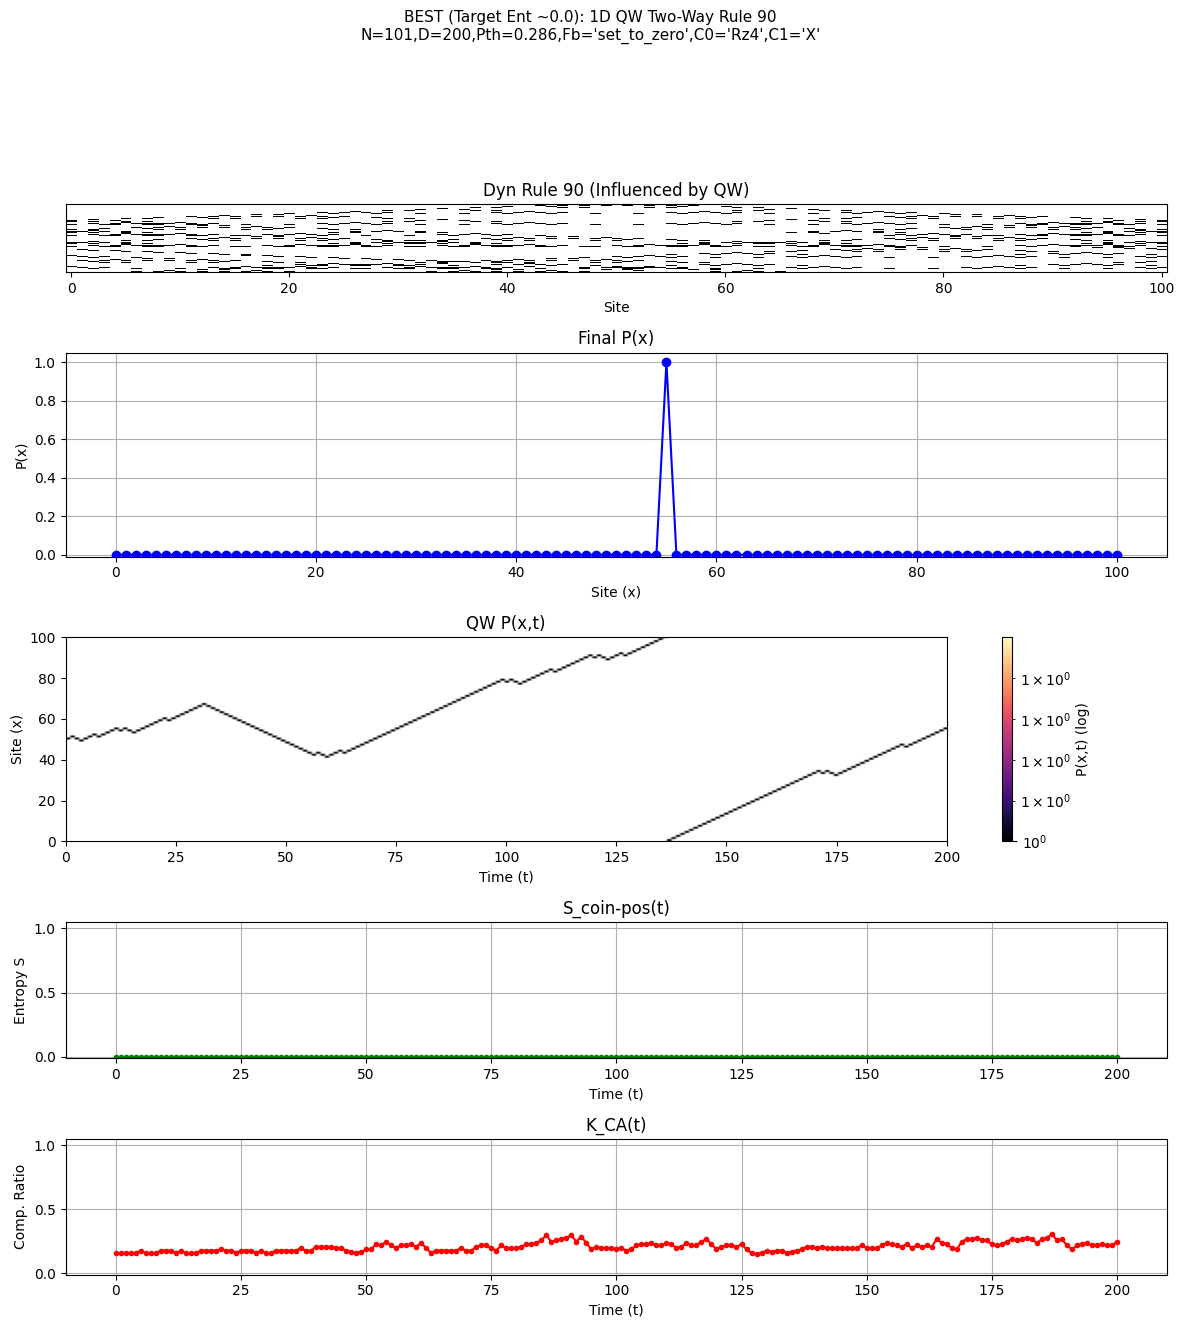


<<<<< END OF EVOLUTIONARY ALGORITHM SIMULATION >>>>>


In [3]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
import zlib
from scipy.signal import find_peaks

# --- Parameters & Defaults ---
N_SITES_1D_DEFAULT = 101
DEPTH_DEFAULT = 200
INITIAL_POS_1D_DEFAULT = N_SITES_1D_DEFAULT // 2
INITIAL_COIN_1D_DEFAULT = 0
INITIAL_CA_CENTER_ONE_DEFAULT = True

# --- CA Rule Update Function ---
def update_ca_line(current_line, rule_number):
    width = len(current_line); new_line = np.zeros(width, dtype=int)
    for i in range(width):
        pattern_val = (current_line[(i-1+width)%width]<<2)|(current_line[i]<<1)|current_line[(i+1)%width]
        if rule_number==30: new_line[i]=1 if pattern_val in [1,2,3,4] else 0
        elif rule_number==90: new_line[i]=1 if current_line[(i-1+width)%width]!=current_line[(i+1)%width] else 0
        elif rule_number==110: new_line[i]=1 if pattern_val in [1,2,3,5,6] else 0
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices & Rz Gate ---
H_1Q = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]],dtype=np.complex128)
I_1Q = np.eye(2,dtype=np.complex128)
def Rz_1Q(angle_rad): return np.array([[np.exp(-1j*angle_rad/2),0],[0,np.exp(1j*angle_rad/2)]],dtype=np.complex128)

# --- Helper Functions (1D QW) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d; initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try: initial_state_vector[get_1d_index(initial_coin_val, initial_pos, n_sites_1d)] = 1.0
    except IndexError as e: print(f"Error during 1D initial state prep: {e}")
    return initial_state_vector

# --- Build QW Step Operator ---
def build_1d_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    state_dim_1d = 2*n_sites_1d
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if current_ca_pattern[site_idx]==0 else coin1_op
        idx_s_c0=get_1d_index(0,site_idx,n_sites_1d); idx_s_c1=get_1d_index(1,site_idx,n_sites_1d)
        C_full[idx_s_c0,idx_s_c0]=chosen_coin_op[0,0]; C_full[idx_s_c1,idx_s_c0]=chosen_coin_op[1,0]
        C_full[idx_s_c0,idx_s_c1]=chosen_coin_op[0,1]; C_full[idx_s_c1,idx_s_c1]=chosen_coin_op[1,1]
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val,site_pos=get_1d_coin_pos_from_index(k_in,n_sites_1d)
        new_pos=(site_pos-1+n_sites_1d)%n_sites_1d if coin_val==0 else (site_pos+1)%n_sites_1d
        S_full[get_1d_index(coin_val,new_pos,n_sites_1d), k_in] = 1.0
    return S_full @ C_full

# --- Observables (1D QW) ---
def calculate_p1_position_1d(sv,n):
    p_dist=np.zeros(n);
    for i in range(n): p_dist[i]=np.abs(sv[get_1d_index(0,i,n)])**2+np.abs(sv[get_1d_index(1,i,n)])**2
    return p_dist

def calculate_coin_position_entanglement_1d(sv,n):
    if np.allclose(sv, 0): return 0.0
    if len(sv)!=2*n:return np.nan
    norm=np.linalg.norm(sv);
    if norm < 1e-9 : return 0.0
    if np.abs(norm-1)>1e-6:sv=sv/norm
    rho=np.outer(sv,np.conj(sv));rho_c=np.zeros((2,2),dtype=np.complex128)
    for i in range(n):
        for r,c in [(x,y) for x in range(2) for y in range(2)]:rho_c[r,c]+=rho[get_1d_index(r,i,n),get_1d_index(c,i,n)]
    tr=np.trace(rho_c)
    if abs(tr) < 1e-9 : return 0.0
    if np.abs(tr-1.0) > 1e-6 : rho_c/=tr
    eigs=np.linalg.eigvalsh(rho_c);ent=0.0
    for e in eigs: ent-=(e*np.log2(e) if e>1e-12 else 0.0)
    return max(0.0,np.real(ent))

def calculate_ca_compressibility(ca_l): return len(zlib.compress("".join(map(str,ca_l)).encode('utf-8')))/len(ca_l) if len(ca_l)>0 else 1.0

# --- Simulation Loop (1D QW with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_two_way_coupling(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    initial_ca_center_one, ca_rule_number, coin0_op, coin1_op,
    p_threshold, feedback_type,
    collect_full_history=False, # For CA, Compressibility
    verbose_debug_run=False,
    debug_genome_desc=""
):
    if verbose_debug_run: # ... (verbose prints) ...
        pass # Add this to fix indentation error.
        # The function continues below... (CA init) ...

    current_qw_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0: # ... (CA init) ...
        center_idx = n_sites_1d // 2
        if n_sites_1d % 2 == 1: current_ca_line[center_idx] = 1
        else: current_ca_line[center_idx - 1] = 1

    # prob_history and ent_history are ALWAYS collected fully
    prob_history = np.full((depth + 1, n_sites_1d), np.nan)
    ent_history = np.full(depth + 1, np.nan)
    prob_history[0, :] = calculate_p1_position_1d(current_qw_state, n_sites_1d)
    ent_history[0] = calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d)

    ca_history = [] if collect_full_history else None
    compressibility_history = [] if collect_full_history else None
    if collect_full_history:
        if ca_history is not None: ca_history.append(current_ca_line.copy())
        if compressibility_history is not None: compressibility_history.append(calculate_ca_compressibility(current_ca_line))

    simulation_status = "completed"

    for step in range(depth):
        if verbose_debug_run: # ... (verbose prints) ...
             print(f"\nDEBUG_EA_STEP {step+1}/{depth}") # Example
             print(f"  QW Norm before U: {np.linalg.norm(current_qw_state):.4e}")


        U_step = build_1d_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)
        if verbose_debug_run and step == 0: # ... (U_step unitarity check) ...
            U_dagger_U = U_step.conj().T @ U_step
            identity_check = np.eye(U_step.shape[0], dtype=np.complex128)
            if not np.allclose(U_dagger_U, identity_check):
                diff_norm = np.linalg.norm(U_dagger_U - identity_check)
                print(f"  WARNING: U_step for step {step+1} may NOT BE UNITARY! Norm of (U_dagger_U - I): {diff_norm:.2e}")

        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)
        if verbose_debug_run: print(f"  QW Norm after U:  {norm_qw:.4e}")

        if abs(norm_qw) > 1e-9 : current_qw_state /= norm_qw
        else:
            if verbose_debug_run: print(f"FAILURE: QW Norm zero at step {step+1}.")
            simulation_status = "failed_zero_norm"
            # prob_history and ent_history initialized with NaNs will remain so from this step
            break

        prob_history[step + 1, :] = calculate_p1_position_1d(current_qw_state, n_sites_1d)
        ent_history[step + 1] = calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d)

        ca_line_for_next_update = current_ca_line.copy()
        for i in range(n_sites_1d):
            if prob_history[step + 1, i] > p_threshold:
                if feedback_type=="flip": ca_line_for_next_update[i]=1-ca_line_for_next_update[i]
                elif feedback_type=="set_to_one": ca_line_for_next_update[i]=1
                elif feedback_type=="set_to_zero": ca_line_for_next_update[i]=0
        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)

        if collect_full_history: # ... (append to ca_history, compressibility_history) ...
            if ca_history is not None: ca_history.append(current_ca_line.copy())
            if compressibility_history is not None: compressibility_history.append(calculate_ca_compressibility(current_ca_line))

    results_dict = {
        "prob_history": prob_history, # Already np.array
        "ent_history": ent_history, # Already np.array
        "params": { "status": simulation_status, # ... other params ...
            "n_sites":n_sites_1d,"depth":depth,"initial_pos":initial_pos,"initial_coin":initial_coin_val,
            "initial_ca_center_one":initial_ca_center_one,"ca_rule_number":ca_rule_number,
            "p_threshold":p_threshold,"feedback_type":feedback_type
        }
    }
    if ca_history is not None: results_dict["ca_history"] = np.array(ca_history)
    if compressibility_history is not None: results_dict["compressibility_history"] = np.array(compressibility_history)
    return results_dict

# --- Fitness Function v2 (targets entanglement) ---
def calculate_particle_fitness_v2(
    prob_history, ent_history, n_sites, depth,
    target_velocity_range=(0.1, 0.5), target_width=5,
    target_entanglement=0.0, entanglement_weight=50.0,
    localization_bonus=100.0, velocity_bonus=50.0, consistency_bonus=30.0, persistence_bonus=1.0
    ):

    # --- Penalties for Failures ---
    if prob_history is None or np.isnan(prob_history).any(): return -2000.0
    if prob_history.shape[0] != (depth + 1) or prob_history.shape[1] != n_sites : return -2100.0
    if ent_history is None or np.isnan(ent_history).any() or len(ent_history) != (depth + 1): return -2200.0

    # --- Particle Score Calculation (from previous fitness function) ---
    particle_score = 0.0
    final_p = prob_history[-1, :]
    if np.sum(final_p) < 1e-6 : particle_score = -1000.0 # No probability mass
    else:
        peaks_final_indices, _ = find_peaks(final_p, height=0.01, distance=max(1, target_width // 2))
        if not peaks_final_indices.any(): particle_score = -100.0 # No distinct peaks
        else:
            num_good_particles = 0; total_particle_score_component = 0.0
            for peak_idx_final in peaks_final_indices:
                current_pos = peak_idx_final; num_steps_tracked = 0; path_positions = [current_pos]
                # Backtracking (simplified from previous)
                for t in range(depth -1 , (depth // 2) -1, -1): # Track latter half
                    p_at_t = prob_history[t, :]
                    if np.isnan(p_at_t).any(): break
                    search_window_min=max(0,current_pos-target_width); search_window_max=min(n_sites,current_pos+target_width+1)
                    if search_window_min>=search_window_max: break
                    window_probs=p_at_t[search_window_min:search_window_max]
                    if not window_probs.any() or np.max(window_probs)<0.001:break
                    prev_pos_candidate=search_window_min+np.argmax(window_probs)
                    if np.abs(prev_pos_candidate-current_pos)<=target_width:
                        current_pos=prev_pos_candidate;path_positions.append(current_pos);num_steps_tracked+=1
                    else: break

                if num_steps_tracked > (depth // 20):
                    path_positions=np.array(path_positions[::-1])
                    velocities=np.diff(path_positions) if len(path_positions)>1 else np.array([])
                    avg_velocity=np.mean(velocities) if len(velocities)>0 else 0.0
                    std_velocity=np.std(velocities) if len(velocities)>1 else (0.0 if len(velocities)==1 else 10.0)
                    vel_consistency_score=1.0/(1.0+std_velocity)
                    vel_magnitude_score=0.0; abs_avg_velocity=np.abs(avg_velocity)
                    if target_velocity_range[0]<=abs_avg_velocity<=target_velocity_range[1]: vel_magnitude_score=1.0
                    elif abs_avg_velocity<target_velocity_range[0] and abs_avg_velocity>1e-3: vel_magnitude_score=0.2*(abs_avg_velocity/target_velocity_range[0])
                    loc_score=final_p[peak_idx_final];
                    if len(peaks_final_indices)>1: loc_score/=(1+0.5*(len(peaks_final_indices)-1))
                    total_particle_score_component+=( (vel_magnitude_score*velocity_bonus) +
                                                     (vel_consistency_score*consistency_bonus) +
                                                     (loc_score*localization_bonus) +
                                                     (num_steps_tracked*persistence_bonus) )
                    num_good_particles+=1
            if num_good_particles > 0: particle_score = total_particle_score_component / num_good_particles
            else: # Fallback if no persistent peaks
                 peak_positions=peaks_final_indices; mean_peak_pos=np.mean(peak_positions); peak_probs_at_final=final_p[peak_positions]
                 squared_deviations=(peak_positions-mean_peak_pos)**2; var_num=np.sum(squared_deviations*peak_probs_at_final); var_den=np.sum(peak_probs_at_final)
                 var_final=var_num/var_den if var_den>1e-9 else n_sites**2
                 particle_score=(np.sum(peak_probs_at_final)*10.0)*(1.0/(1.0+np.sqrt(max(0,var_final))))-50.0

    # --- Entanglement Score Component ---
    # Average entanglement in the latter half of the simulation
    avg_entanglement = np.mean(ent_history[len(ent_history)//2:])

    # Score based on deviation from target_entanglement
    # Higher score if closer to target. Max score component is entanglement_weight.
    ent_deviation_score = entanglement_weight * (1.0 - np.abs(avg_entanglement - target_entanglement) / (1.0 if target_entanglement <= 0.5 else target_entanglement) ) # Normalize diff by target if target is high
    # Simpler: just reward difference from target:
    # ent_deviation_score = -entanglement_weight * np.abs(avg_entanglement - target_entanglement)

    combined_fitness = particle_score + ent_deviation_score

    if np.isnan(combined_fitness) or np.isinf(combined_fitness): combined_fitness = -3000.0
    return combined_fitness


# --- EA Helper Functions, Plotting, Summary (as before, ensure they use results dict correctly) ---
# (Using the versions from the previous full code block for initialize_population,
#  select_parents_tournament, crossover_genome, mutate_genome,
#  plot_1d_qw_results_two_way, generate_1d_qw_text_output_two_way)
def initialize_population(pop_size, param_choices_dict):
    population = []
    for _ in range(pop_size):
        genome = {
            "ca_rule": np.random.choice(param_choices_dict["ca_rules"]),
            "c0_name": np.random.choice(list(param_choices_dict["coin_ops_dict"].keys())),
            "c1_name": np.random.choice(list(param_choices_dict["coin_ops_dict"].keys())),
            "p_thresh": np.random.uniform(param_choices_dict["p_thresh_range"][0], param_choices_dict["p_thresh_range"][1]),
            "feedback": np.random.choice(param_choices_dict["feedbacks"])
        }
        population.append(genome)
    return population

def select_parents_tournament(population, fitnesses, tournament_size=3, num_parents=None):
    if num_parents is None: num_parents = len(population)
    if not population: return []
    selected_parents = [];
    for _ in range(num_parents):
        actual_tournament_size = min(tournament_size, len(population))
        if actual_tournament_size == 0: break
        comp_idx = np.random.choice(len(population), actual_tournament_size, replace=False)
        comp_fitnesses = np.array(fitnesses)[comp_idx] if fitnesses else np.array([-float('inf')] * len(comp_idx))
        win_idx_in_comp = np.argmax(comp_fitnesses)
        win_idx_in_pop = comp_idx[win_idx_in_comp]
        selected_parents.append(population[win_idx_in_pop])
    return selected_parents

def crossover_genome(p1,p2):
    o1,o2=p1.copy(),p2.copy();keys=list(p1.keys())
    if len(keys)>1:pt=np.random.randint(1,len(keys));
    for i in range(pt,len(keys)):k=keys[i];o1[k],o2[k]=o2[k],o1[k]
    return o1,o2

def mutate_genome(g,p_choices,mut_rate):
    mg=g.copy()
    for k in g:
        if np.random.rand()<mut_rate:
            if k=="ca_rule":mg[k]=np.random.choice(p_choices["ca_rules"])
            elif k=="c0_name":mg[k]=np.random.choice(list(p_choices["coin_ops_dict"].keys()))
            elif k=="c1_name":mg[k]=np.random.choice(list(p_choices["coin_ops_dict"].keys()))
            elif k=="p_thresh":mg[k]=np.random.uniform(p_choices["p_thresh_range"][0],p_choices["p_thresh_range"][1])
            elif k=="feedback":mg[k]=np.random.choice(p_choices["feedbacks"])
    return mg

def plot_1d_qw_results_two_way(results, suptitle_prefix=""):
    params = results["params"]; prob_hist = results.get("prob_history", np.array([]))
    ent_hist = results.get("ent_history", [])
    ca_hist = results.get("ca_history", [])
    compress_hist = results.get("compressibility_history", [])

    depth = params['depth']; ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']
    c0_name = params.get("coin0_name", "C0")
    c1_name = params.get("coin1_name", "C1")
    n_sites_val = params['n_sites']

    num_main_plots = 1
    plot_height_ratios = []

    if ca_hist is not None and len(ca_hist) > 0: num_main_plots +=1; plot_height_ratios.append(1)
    plot_height_ratios.append(3)
    if prob_hist is not None and prob_hist.ndim == 2 and prob_hist.shape[0] > 1 : num_main_plots +=1; plot_height_ratios.append(3)
    if ent_hist is not None and len(ent_hist) > 0: num_main_plots +=1; plot_height_ratios.append(2)
    if compress_hist is not None and len(compress_hist) > 0: num_main_plots +=1; plot_height_ratios.append(2)

    if not plot_height_ratios : print("No plottable data."); return

    fig, axs = plt.subplots(num_main_plots, 1, figsize=(12, 2.5 * num_main_plots + 1),
                            gridspec_kw={'height_ratios': plot_height_ratios})
    if num_main_plots == 1: axs = [axs]

    title_str = (f"{suptitle_prefix}1D QW Two-Way Rule {ca_rule_number}\n"
                 f"N={n_sites_val},D={depth},Pth={p_thresh:.3f},Fb='{feedback}',C0='{c0_name}',C1='{c1_name}'")
    fig.suptitle(title_str, fontsize=11); pidx=0

    if ca_hist is not None and len(ca_hist) > 0:
        axs[pidx].imshow(ca_hist,cmap='binary',aspect='auto',interpolation='nearest');axs[pidx].set_title(f"Dyn Rule {ca_rule_number} (Influenced by QW)");axs[pidx].set_xlabel("Site");axs[pidx].set_yticks([]);pidx+=1
    elif num_main_plots > pidx and plot_height_ratios[pidx] == 1:
        axs[pidx].text(0.5,0.5,"CA History Unavailable",ha='center',va='center'); pidx+=1


    if prob_hist is not None and prob_hist.size > 0 and prob_hist.ndim == 2:
        axs[pidx].plot(np.arange(n_sites_val),prob_hist[-1,:],marker='o',ls='-',color='b');axs[pidx].set_title("Final P(x)");axs[pidx].set_xlabel("Site (x)");axs[pidx].set_ylabel("P(x)");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01);pidx+=1
    elif prob_hist is not None and prob_hist.size > 0 and prob_hist.ndim == 1:
        axs[pidx].plot(np.arange(n_sites_val),prob_hist,marker='o',ls='-',color='b');axs[pidx].set_title("Final P(x)");axs[pidx].set_xlabel("Site (x)");axs[pidx].set_ylabel("P(x)");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01);pidx+=1
    else: axs[pidx].text(0.5,0.5,"Prob data unavailable",ha='center',va='center'); pidx+=1

    if prob_hist is not None and prob_hist.ndim == 2 and prob_hist.shape[0] > 1:
        prob_st=prob_hist.T;pos_p=prob_st[prob_st>1e-9];min_v=pos_p.min() if len(pos_p)>0 else 1e-9;max_v=prob_st.max()
        norm_v=colors.LogNorm(vmin=min_v,vmax=max(max_v,min_v+1e-6));im=axs[pidx].imshow(prob_st,aspect='auto',origin='lower',cmap='magma',norm=norm_v,extent=[0,depth,0,n_sites_val-1])
        plt.colorbar(im,ax=axs[pidx],label="P(x,t) (log)");axs[pidx].set_title("QW P(x,t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Site (x)");pidx+=1
    elif num_main_plots > pidx and plot_height_ratios[pidx] == 3 :
        axs[pidx].text(0.5,0.5,"P(x,t) History Unavailable",ha='center',va='center'); pidx+=1

    if ent_hist is not None and len(ent_hist) > 0:
        ts=np.arange(len(ent_hist));axs[pidx].plot(ts,ent_hist,marker='.',ls='-',color='g');axs[pidx].set_title("S_coin-pos(t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Entropy S");axs[pidx].grid(True);axs[pidx].set_ylim(bottom=-0.01,top=1.05);pidx+=1
    elif num_main_plots > pidx and len(plot_height_ratios) > pidx and plot_height_ratios[pidx] == 2:
        axs[pidx].text(0.5,0.5,"Entanglement History Unavailable",ha='center',va='center'); pidx+=1

    if compress_hist is not None and len(compress_hist)>0:
        ts_comp=np.arange(len(compress_hist));axs[pidx].plot(ts_comp,compress_hist,marker='.',ls='-',color='r');axs[pidx].set_title("K_CA(t)");axs[pidx].set_xlabel("Time (t)");axs[pidx].set_ylabel("Comp. Ratio");axs[pidx].grid(True);max_k_val=np.max(compress_hist[np.isfinite(compress_hist)]) if len(compress_hist[np.isfinite(compress_hist)])>0 else 1;axs[pidx].set_ylim(bottom=-0.01,top=max(1.05,max_k_val+0.05));pidx+=1
    elif num_main_plots > pidx and len(plot_height_ratios) > pidx and plot_height_ratios[pidx] == 2:
        axs[pidx].text(0.5,0.5,"Compressibility History Unavailable",ha='center',va='center'); pidx+=1

    plt.tight_layout(rect=[0,0,1,0.90 if num_main_plots > 3 else 0.88]);plt.show()

def generate_1d_qw_text_output_two_way(results, genome_params_for_ea=None):
    # ... (same as previous version, ensure it handles potentially None histories) ...
    params = results["params"]; prob_hist = results.get("prob_history", np.array([]))
    ent_hist = results.get("ent_history", [])
    compress_hist = results.get("compressibility_history", [])

    ca_rule_number = params['ca_rule_number']; p_thresh = params['p_threshold']; feedback = params['feedback_type']
    c0_name = genome_params_for_ea.get("c0_name", "N/A") if genome_params_for_ea else params.get("coin0_name", "C0")
    c1_name = genome_params_for_ea.get("c1_name", "N/A") if genome_params_for_ea else params.get("coin1_name", "C1")
    n_sites_val = params['n_sites']

    output_lines = [f"\n--- 1D QW (Rule {ca_rule_number},Pth={p_thresh:.3f},Fb='{feedback}',C0='{c0_name}',C1='{c1_name}') Summary ---"]
    output_lines.append(f"N_sites={n_sites_val}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")
    if "status" in params: output_lines.append(f"Simulation Status: {params['status']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    if prob_hist.size > 0 and prob_hist.ndim == 2 and prob_hist.shape[0] > 0 and not np.isnan(prob_hist[-1, :]).all():
        final_probs = prob_hist[-1, :]; sorted_indices = np.argsort(final_probs)[::-1]
        for i in range(min(5, n_sites_val)): idx = sorted_indices[i]; output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")
    else: output_lines.append("  (Final probability data not available or all NaN)")

    ent_hist = ent_hist if ent_hist is not None else []
    compress_hist = compress_hist if compress_hist is not None else []

    if len(ent_hist)>0:
        output_lines.append("\nCoin-Position Entanglement vs. Time:")
        num_steps_total = len(ent_hist)
        indices_to_show = [0] + ([num_steps_total // 2] if num_steps_total > 2 else []) + ([num_steps_total - 1] if num_steps_total > 1 else [])
        for idx in sorted(list(set(indices_to_show))):
            s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"; output_lines.append(f"  Step {idx}: S = {s_val_str}")

    if len(compress_hist)>0:
        output_lines.append("\nCA Pattern Compressibility vs. Time:")
        for idx in sorted(list(set(indices_to_show))):
            k_val_str = f"{compress_hist[idx]:.6f}" if np.isfinite(compress_hist[idx]) else "nan"; output_lines.append(f"  Step {idx}: K_CA = {k_val_str}")
        if len(compress_hist) > 0 and np.isfinite(compress_hist[-1]): output_lines.append(f"  Final K_CA: {compress_hist[-1]:.6f}")
        else: output_lines.append("  Final K_CA: nan")

    output_lines.append("--- End Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (Evolutionary Algorithm) ---
if __name__ == "__main__":

    POPULATION_SIZE = 20
    NUM_GENERATIONS = 10
    MUTATION_RATE = 0.15
    TOURNAMENT_SIZE = 3
    EA_N_SITES = 51
    EA_DEPTH = 100
    EA_INITIAL_POS = EA_N_SITES // 2
    EA_INITIAL_COIN = INITIAL_COIN_1D_DEFAULT
    EA_INITIAL_CA_CENTER = INITIAL_CA_CENTER_ONE_DEFAULT

    Rz_pi_4 = Rz_1Q(np.pi/4); Rz_pi_2 = Rz_1Q(np.pi/2)
    coin_op_dict = { "H": H_1Q, "X": X_1Q, "I": I_1Q, "XH": X_1Q @ H_1Q,
                     "HX": H_1Q @ X_1Q, "Rz4": Rz_pi_4, "Rz2": Rz_pi_2 }
    param_choices = {
        "ca_rules": [30, 90, 110], "coin_ops_dict": coin_op_dict,
        "p_thresh_range": (0.01, 0.3),
        "feedbacks": ["flip", "set_to_one", "set_to_zero"]
    }

    # --- Select EA Target ---
    # TARGET_ENTANGLEMENT_LOW = 0.0  # For classical-like particles
    # TARGET_ENTANGLEMENT_HIGH = 0.9 # For quantum-like localized particles

    current_target_entanglement = 0.0 # Start by searching for classical-like
    current_entanglement_weight = 50.0

    print(f"Starting Evolutionary Algorithm targeting Entanglement ~ {current_target_entanglement}...")
    print(f"Population: {POPULATION_SIZE}, Generations: {NUM_GENERATIONS}, Sim Depth: {EA_DEPTH}\n")

    population = initialize_population(POPULATION_SIZE, param_choices)
    best_genome_overall = None
    best_fitness_overall = -float('inf')
    verbose_debug_triggered_this_ea = False

    for gen in range(NUM_GENERATIONS):
        if verbose_debug_triggered_this_ea:
            print(f"Gen {gen+1}: Skipping evaluations due to prior verbose debug trigger.")
            fitness_scores = [-float('inf')] * len(population) # Corrected to use -inf
        else:
            fitness_scores = []
            gen_best_fitness_local = -float('inf')
            gen_best_genome_local = None

            for i, genome in enumerate(population):
                # EA runs now always collect prob_history and ent_history
                results = run_1d_qw_two_way_coupling(
                    n_sites_1d=EA_N_SITES, depth=EA_DEPTH,
                    initial_pos=EA_INITIAL_POS, initial_coin_val=EA_INITIAL_COIN,
                    initial_ca_center_one=EA_INITIAL_CA_CENTER,
                    ca_rule_number=genome["ca_rule"],
                    coin0_op=param_choices["coin_ops_dict"][genome["c0_name"]],
                    coin1_op=param_choices["coin_ops_dict"][genome["c1_name"]],
                    p_threshold=genome["p_thresh"], feedback_type=genome["feedback"],
                    collect_full_history=False, # False means only prob and ent history
                    verbose_debug_run=False
                )

                current_fitness = calculate_particle_fitness_v2(
                    results["prob_history"], results["ent_history"],
                    EA_N_SITES, EA_DEPTH,
                    target_entanglement=current_target_entanglement,
                    entanglement_weight=current_entanglement_weight
                )
                fitness_scores.append(current_fitness)

                if results["params"].get("status") == "failed_zero_norm" and not verbose_debug_triggered_this_ea:
                    print(f"\n!!! Genome caused zero norm. Triggering VERBOSE DEBUG RUN (Gen {gen+1}, Genome {i}) !!!")
                    print(f"Genome: {genome}")
                    run_1d_qw_two_way_coupling(
                        n_sites_1d=EA_N_SITES, depth=EA_DEPTH,
                        initial_pos=EA_INITIAL_POS, initial_coin_val=EA_INITIAL_COIN,
                        initial_ca_center_one=EA_INITIAL_CA_CENTER,
                        ca_rule_number=genome["ca_rule"],
                        coin0_op=param_choices["coin_ops_dict"][genome["c0_name"]],
                        coin1_op=param_choices["coin_ops_dict"][genome["c1_name"]],
                        p_threshold=genome["p_thresh"], feedback_type=genome["feedback"],
                        collect_full_history=True, verbose_debug_run=True,
                        debug_genome_desc=f"Gen {gen+1} Genome {i}"
                    )
                    verbose_debug_triggered_this_ea = True

                if current_fitness > gen_best_fitness_local:
                    gen_best_fitness_local = current_fitness; gen_best_genome_local = genome
                if current_fitness > best_fitness_overall:
                    best_fitness_overall = current_fitness; best_genome_overall = genome

        avg_fitness_gen = np.mean(fitness_scores) if fitness_scores else -float('inf')
        print(f"Gen {gen+1}: Avg Fitness: {avg_fitness_gen:.2f}, Gen Best: {gen_best_fitness_local:.2f} (Target Ent ~{current_target_entanglement}, Overall Best: {best_fitness_overall:.2f})")

        if verbose_debug_triggered_this_ea:
            print("Stopping EA early after verbose debug run.")
            break
        # ... (EA population update logic as before) ...
        if not population :
            population = initialize_population(POPULATION_SIZE, param_choices); continue
        parents = select_parents_tournament(population, fitness_scores, TOURNAMENT_SIZE)
        next_population = []
        if parents:
            num_offspring_to_generate = POPULATION_SIZE
            if gen_best_genome_local is not None and gen_best_fitness_local > -1999.0 :
                num_offspring_to_generate -=1
            for i in range(0, num_offspring_to_generate, 2):
                if len(parents) < 2:
                     if parents:
                          next_population.append(mutate_genome(parents[0], param_choices, MUTATION_RATE))
                          if len(next_population) < POPULATION_SIZE:
                              next_population.append(mutate_genome(parents[0], param_choices, MUTATION_RATE))
                     break
                p1_idx = np.random.randint(len(parents)); p2_idx = np.random.randint(len(parents))
                parent1, parent2 = parents[p1_idx], parents[p2_idx]
                offspring1, offspring2 = crossover_genome(parent1, parent2)
                next_population.append(mutate_genome(offspring1, param_choices, MUTATION_RATE))
                if len(next_population) < POPULATION_SIZE:
                     next_population.append(mutate_genome(offspring2, param_choices, MUTATION_RATE))
        if gen_best_genome_local and gen_best_fitness_local > -1999.0 :
            is_gen_best_in_next_pop = any(gen_best_genome_local == ind for ind in next_population)
            if not is_gen_best_in_next_pop:
                if len(next_population) < POPULATION_SIZE: next_population.append(gen_best_genome_local.copy())
                elif next_population :
                    rand_idx_replace = np.random.randint(0, len(next_population))
                    next_population[rand_idx_replace] = gen_best_genome_local.copy()
        while len(next_population) < POPULATION_SIZE: next_population.extend(initialize_population(1, param_choices))
        if len(next_population) > POPULATION_SIZE: next_population = next_population[:POPULATION_SIZE]
        if not next_population and POPULATION_SIZE > 0:
             next_population = initialize_population(POPULATION_SIZE, param_choices)
        population = next_population
        if not population and POPULATION_SIZE > 0 :
            print("Error: Population became empty during EA. Stopping."); break


    print("\n--- Evolutionary Algorithm Finished (or stopped for debug) ---")
    if verbose_debug_triggered_this_ea:
        print("EA was stopped for verbose debugging. The 'best_genome_overall' may not be truly optimal.")

    if best_genome_overall and best_fitness_overall > -1999.0:
        print(f"Best Genome Found Overall (Fitness: {best_fitness_overall:.4f} for Target Ent ~{current_target_entanglement}):")
        print(best_genome_overall)
        print("\n--- Running Final Simulation with Best Genome Found (Full History & Plotting) ---")
        final_run_depth = DEPTH_DEFAULT
        final_n_sites = N_SITES_1D_DEFAULT
        final_initial_pos = INITIAL_POS_1D_DEFAULT
        best_c0 = param_choices["coin_ops_dict"][best_genome_overall["c0_name"]]
        best_c1 = param_choices["coin_ops_dict"][best_genome_overall["c1_name"]]
        final_results = run_1d_qw_two_way_coupling(
            n_sites_1d=final_n_sites, depth=final_run_depth,
            initial_pos=final_initial_pos, initial_coin_val=INITIAL_COIN_1D_DEFAULT,
            initial_ca_center_one=INITIAL_CA_CENTER_ONE_DEFAULT,
            ca_rule_number=best_genome_overall["ca_rule"],
            coin0_op=best_c0, coin1_op=best_c1,
            p_threshold=best_genome_overall["p_thresh"], feedback_type=best_genome_overall["feedback"],
            collect_full_history=True, verbose_debug_run=False
        )
        final_results["params"]["coin0_name"] = best_genome_overall["c0_name"]
        final_results["params"]["coin1_name"] = best_genome_overall["c1_name"]
        final_results["params"]["n_sites"] = final_n_sites
        final_summary = generate_1d_qw_text_output_two_way(final_results, genome_params_for_ea=best_genome_overall)
        print(final_summary)
        plot_1d_qw_results_two_way(final_results, suptitle_prefix=f"BEST (Target Ent ~{current_target_entanglement}): ")
    elif best_genome_overall:
        print(f"EA completed. Best genome recorded (possibly failing during EA eval) was (Fitness {best_fitness_overall:.2f}): {best_genome_overall}")
        if not verbose_debug_triggered_this_ea:
             print("Consider re-running this genome with verbose_debug_run=True manually if needed.")
    else:
        print("No best genome found (or EA stopped early for debug before any genome completed a run).")

    print("\n<<<<< END OF EVOLUTIONARY ALGORITHM SIMULATION >>>>>")

Classical Emergence: This system demonstrates how classical-like behavior (a localized particle with a definite trajectory and no internal quantum entanglement with its path) can emerge from underlying quantum rules through specific interactions and feedback with a rule-based environment.